In [1]:
import numpy as np
import pygame
import random
import math
from matplotlib import pyplot as plt

class swarm():
    def __init__(self, func, lowerbounds=[], upperbounds=[], number_of_particles=50, display=False,
                 migrationexists=True, pmig=0.15):
        self.lowerbounds  = lowerbounds
        self.upperbounds  = upperbounds
        self.nop          = number_of_particles
        self.display      = display
        self.func         = func
        self._vel_max     = 20.0
        self._vel_min     = -20.0
        self.member       = {}
        self.pmig         = pmig
        self.iteration_no = 0
        self.migrationexists = migrationexists
        self.__coefficients()
        
        if self.func.__name__   == 'egg':
            self.lowerbounds  = [-512,-512]
            self.upperbounds  = [512,512]
        elif self.func.__name__ == 'griewank':
            self.lowerbounds  = [-600,-600]
            self.upperbounds  = [600,600]
        
        if self.display:
            self.screen       = pygame.display.set_mode((self.upperbounds[0]-self.lowerbounds[0],
                                                         self.upperbounds[1]-self.lowerbounds[1]))
            pygame.display.set_caption("Particle Swarm Optimization")
            self.screen.fill(self.WHITE)
                    
        for ii in range(self.nop):
            self.member[str(ii)] = {'center':(0,0)}
            self.member[str(ii)]['best_value'] = 10**8
            
            self.member[str(ii)]['position']      = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['best_position'] = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['velocity']      = {str(jj): np.random.random()\
                                                     for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
        
        self._evaluate_fitness()
        self._distance()
    
    def __coefficients(self):
        self.BLUE  = (0,0,255)
        self.WHITE = (255,255,255)
        self.BLACK = (0,0,0)
        self.RED   = (255,0,0)
        self.__coefficients         = {}
        self.__coefficients['eta0'] = 1.0
        self.__coefficients['wght'] = 0.0196
        self.__coefficients['eta1'] = 3.9804
        self.__coefficients['eta2'] = 0.2157
        self.__coefficients['eta3'] = 3.2353
        self.__coefficients['eta4'] = 0.5098
        
    def _evaluate_fitness(self):
        '''evaluates the fitness function for the members of the swarm'''
        self.fitness_values = {'_'           :{},
                               'sorted'      :{},
                               'best'        :{},
                               'best_sorted' :{}}
        for ii in range(self.nop):
            self.member[str(ii)]['fitness_value'] = self.func([self.member[str(ii)]\
                                                    ['position'][str(jj)] for jj in\
                                                    range(len(self.lowerbounds))])
            
            if self.member[str(ii)]['fitness_value']<self.member[str(ii)]['best_value']:
                self.member[str(ii)]['best_value'] = self.member[str(ii)]['fitness_value']
                for jj in range(len(self.lowerbounds)):
                    self.member[str(ii)]['best_position'][str(jj)] = self.member[str(ii)]['position'][str(jj)]
        
            self.fitness_values['_'][str(ii)]    = self.member[str(ii)]['fitness_value']
            self.fitness_values['best'][str(ii)] = self.member[str(ii)]['best_value']

        self._sorted_fitness_value    = sorted(self.fitness_values['_'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['sorted'] = {str(self._sorted_fitness_value[ii][0]):self._sorted_fitness_value[ii][1]\
                                         for ii in range(self.nop)}
        
        self._sorted_best_value       = sorted(self.fitness_values['best'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['best_sorted'] = {str(self._sorted_best_value[ii][0]):self._sorted_best_value[ii][1]\
                                              for ii in range(self.nop)}
        
        
        self.best_position      = {list(self.fitness_values['sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['sorted'].keys())[ii]]['position']\
                                  for ii in range(self.nop)}
        
        self.best_position_ever = {list(self.fitness_values['best_sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['best_sorted'].keys())[ii]]['best_position']\
                                  for ii in range(self.nop)}
            
    def _distance(self):
        '''calculates the distances between the members of the swarm'''
        for ii in range(self.nop):
            self.member[str(ii)]['distance'] = {str(jj): {str(kk): self.member[str(ii)]['position'][str(kk)]-\
                                                         self.member[str(jj)]['position'][str(kk)]\
                                                         for kk in range(len(self.lowerbounds))}\
                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['distance_sorted'] = {str(jj):sorted(np.abs(self.member[str(ii)]['distance']\
                                                      [str(kk)][str(jj)]) for kk in range(self.nop)) for jj in\
                                                       range(len(self.lowerbounds))}
            
            self.member[str(ii)]['abs_distance'] = {str(jj): np.sqrt(math.fsum(self.member[str(ii)]['distance']\
                                                             [str(jj)][str(kk)]**2 for kk in\
                                                             range(len(self.lowerbounds)))) for jj in\
                                                             range(self.nop)}
            
            self.member[str(ii)]['abs_distance_sorted'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][1] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][0] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours_fitness_values'] = {self.member[str(ii)]['closest_neighbours'][jj]:\
                                                                         self.member[self.member[str(ii)]['closest_neighbours'][jj]]['fitness_value']\
                                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['closest_neigbours_best'] = sorted(list(self.member[str(ii)]\
                                                                 ['closest_neighbours_fitness_values'].items())[1:5],
                                                                 key=lambda kv:(kv[1],kv[0]))[0][0]
            
            '''distance from the closest particle which has the best fitness value'''
            self.member[str(ii)]['distance_from_closest_best'] = self.member[str(ii)]['distance']\
                                                                [self.member[str(ii)]['closest_neigbours_best']]
            
    def _migration(self):
        '''migration calculations are generated if there exists migration'''
        if np.random.random() < self.pmig:
            self.migration = True
            self.nowp  = int(np.round(0.20*self.nop))        # number of worst particles
            self.nobp  = int(np.round(0.20*self.nop))        # number of best particles
            self.w2bp  = self._sorted_fitness_value[::-1]    # sorted worst to best particles and fitnesses
            self.b2wp  = self._sorted_fitness_value          # sorted best to worst particles and fitnesses
            self.bafv  = np.average([self._sorted_fitness_value[ii][1]\
                                    for ii in range(self.nobp)]) # best average fitness value
            self.bapos = {str(jj): np.average([self.member[self._sorted_fitness_value[ii][0]]\
                                              ['position'][str(jj)] for ii in range(self.nobp)])\
                                              for jj in range(len(self.lowerbounds))} # best average positions
            self.worst_particle_indices = {}
            counter = 0
            for ii in range(4):
                # worst particle indices are seperated 4 sub-groups from worst to best
                self.worst_particle_indices[ii] = [self.w2bp[counter+ii][0] for\
                                                   ii in range(int(np.round(0.25*self.nowp)))]
                counter = counter + int(np.round(0.25*self.nowp))
                
            for ind in (self.worst_particle_indices[0]):
                self.member[str(ind)]['position'] = {str(jj): np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              self.lowerbounds[jj] for jj in\
                                                              range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[1]):
                self.member[str(ind)]['position'] = {str(jj): 0.10*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              np.random.permutation([-1,1])[0]*self.bapos[str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[2]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[3]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position_ever.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
            
            for ii in range(4):
                for ind in (self.worst_particle_indices[ii]):
                    for jj in range(len(self.lowerbounds)):
                        if self.member[str(ind)]['position'][str(jj)] > self.upperbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.upperbounds[jj]
                        elif self.member[str(ind)]['position'][str(jj)] < self.lowerbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.lowerbounds[jj]
                            
        else:
            self.migration    = False
                    
    def _optimize(self):
        '''PSO algoritm'''
        for ii in range(self.nop):
            for jj in range(len(self.lowerbounds)):
                self.member[str(ii)]['velocity'][str(jj)] =  self.__coefficients['eta0'] * np.random.random()*\
                                                             ((self.__coefficients['wght'] * \
                                                             self.member[str(ii)]['velocity'][str(jj)]) + \
                                                             self.__coefficients['eta1'] * np.random.random() * \
                                                             self.member[str(ii)]['best_position'][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta2'] * np.random.random() * \
                                                             list(self.best_position.values())[0][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta3'] * np.random.random() * \
                                                             list(self.member[str(ii)]['distance_sorted'].values())[jj][1] + \
                                                             self.__coefficients['eta4'] * np.random.random() * \
                                                             self.member[str(ii)]['distance_from_closest_best']\
                                                             [str(jj)])
        
                if self.member[str(ii)]['velocity'][str(jj)] > self._vel_max:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_max
                elif self.member[str(ii)]['velocity'][str(jj)] < self._vel_min:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_min
                    
                self.member[str(ii)]['position'][str(jj)] = self.member[str(ii)]['position'][str(jj)] + \
                                                            self.member[str(ii)]['velocity'][str(jj)]
                
                if self.member[str(ii)]['position'][str(jj)] > self.upperbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.upperbounds[jj]
                elif self.member[str(ii)]['position'][str(jj)] < self.lowerbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.lowerbounds[jj]
             
    def update(self,iteration=50): 
        '''updates the position and velocity of the members of the swarm'''
        self.iteration = iteration
        for iter_no in range(self.iteration):
            self.iteration_no = self.iteration_no + 1
            self._optimize()
            self._evaluate_fitness()
            self._distance()
            if self.migrationexists:
                self._migration()
                if self.migration:
                    self._evaluate_fitness()
                    self._distance()

            for ii in range(self.nop):
                self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])\
                                                      -self.lowerbounds[0]),
                                                  int(np.round(self.member[str(ii)]['position']['1'])\
                                                      +self.upperbounds[0]))
                if self.display:
                    pygame.draw.circle(self.screen,self.BLUE,self.member[str(ii)]['center'],2)

            if self.display:
                pygame.display.flip()     
                self.screen.fill(self.WHITE)
                
            print('iteration no       : ',self.iteration_no)
            print('migration          : ',self.migration)
            print('best_particle      : ',list(self.best_position.keys())[0])
            print('best_position      : ',self.member[list(self.best_position.keys())[0]]['best_position'])
            print('best_value         : ',self.member[list(self.best_position.keys())[0]]['fitness_value'])
            print('best_particle_ever : ',list(self.best_position_ever.keys())[0])
            print('best_position_ever : ',self.member[list(self.best_position_ever.keys())[0]]['best_position'])
            print('best_value_ever    : ',self.member[list(self.best_position_ever.keys())[0]]['best_value'])
            print('--------------------------------------------------------')

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def egg(*args):
    x1    = args[0][0]
    x2    = args[0][1]
    term1 = -(x2+47) * math.sin(math.sqrt(math.fabs(x2+x1/2+47)))
    term2 = -x1 * math.sin(math.sqrt(math.fabs(x1-(x2+47))))
    out   = term1 + term2
    return out

def griewank(*args):
    d    = len(args[0])
    sum  = 0
    prod = 1
    for ii in range(d):
        xi   = args[0][ii]
        sum  = sum + xi**2/4000
        prod = prod * math.cos(xi/math.sqrt(ii+1))
    out = sum - prod + 1
    return out

def bukin6(*args):
    x1 = args[0][0]
    x2 = args[0][1]    
    term1 = 100 * math.sqrt((abs(x2-0.01*x1**2)))
    term2 = 0.01 * abs(x1+10)    
    out = term1 + term2
    return out

def ackley(*args):
    d    = len(args[0])
    c    = math.pi * 2
    b    = 0.20
    a    = 20
    
    sum1 = 0
    sum2 = 0
    
    for ii in range(d):
        xi   = args[0][ii]
        sum1 = sum1 + xi**2
        sum2 = sum2 + math.cos(c*xi)
    
    term1 = -a * math.exp(-b*math.sqrt(sum1/d))
    term2 = -math.exp(sum2/d)
    
    y = term1 + term2 + a + math.exp(1)
    
    return y

def drop(*args):
    x1 = args[0][0]
    x2 = args[0][1]
    frac1 = 1+math.cos(12*math.sqrt(x1**2 + x2**2))
    frac2 = 0.5*(x1**2 + x2**2) + 2
    out = -frac1/frac2
    return out

In [3]:
fitness_function             = {}
fitness_function['egg']      = egg
fitness_function['griewank'] = griewank
fitness_function['bukin6']   = bukin6
fitness_function['ackley']   = ackley
fitness_function['drop']     = drop

In [4]:
particles = swarm(func=fitness_function['egg'],number_of_particles=100,display=False)

In [5]:
particles.update(iteration=50)

iteration no       :  1
migration          :  True
best_particle      :  48
best_position      :  {'0': 478.21821332693844, '1': 436.1539714557347}
best_value         :  -856.5257020157193
best_particle_ever :  48
best_position_ever :  {'0': 478.21821332693844, '1': 436.1539714557347}
best_value_ever    :  -856.5257020157193
--------------------------------------------------------
iteration no       :  2
migration          :  False
best_particle      :  95
best_position      :  {'0': -466.2180082229494, '1': 392.613361808808}
best_value         :  -879.2289448031685
best_particle_ever :  95
best_position_ever :  {'0': -466.2180082229494, '1': 392.613361808808}
best_value_ever    :  -879.2289448031685
--------------------------------------------------------
iteration no       :  3
migration          :  True
best_particle      :  1
best_position      :  {'0': 492.0, '1': 441.288065103444}
best_value         :  -912.0139416810651
best_particle_ever :  1
best_position_ever :  {'0': 492.0, 

iteration no       :  24
migration          :  False
best_particle      :  19
best_position      :  {'0': 512, '1': 404.2581434263481}
best_value         :  -959.6398739562096
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.6398739562096
--------------------------------------------------------
iteration no       :  25
migration          :  False
best_particle      :  35
best_position      :  {'0': 512.0, '1': 407.59276254379233}
best_value         :  -946.5505417811256
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.6398739562096
--------------------------------------------------------
iteration no       :  26
migration          :  False
best_particle      :  15
best_position      :  {'0': 512, '1': 404.6659224214352}
best_value         :  -959.4258090942076
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.

iteration no       :  47
migration          :  False
best_particle      :  39
best_position      :  {'0': 512, '1': 402.8633039591022}
best_value         :  -957.5320122408252
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.6398739562096
--------------------------------------------------------
iteration no       :  48
migration          :  False
best_particle      :  39
best_position      :  {'0': 512, '1': 402.8633039591022}
best_value         :  -924.4263611268123
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.6398739562096
--------------------------------------------------------
iteration no       :  49
migration          :  True
best_particle      :  81
best_position      :  {'0': 512, '1': 404.0616013008338}
best_value         :  -959.6077670940198
best_particle_ever :  19
best_position_ever :  {'0': 512, '1': 404.2581434263481}
best_value_ever    :  -959.6398

In [6]:
particles.best_position_ever

{'19': {'0': 512, '1': 404.2581434263481},
 '61': {'0': 512, '1': 404.30958014171},
 '81': {'0': 512, '1': 404.0616013008338},
 '15': {'0': 512, '1': 404.6659224214352},
 '74': {'0': 512.0, '1': 405.0099964306569},
 '53': {'0': 512, '1': 405.16531219886446},
 '8': {'0': 512, '1': 405.1674656009588},
 '39': {'0': 512, '1': 402.8633039591022},
 '3': {'0': 512, '1': 405.6668380260386},
 '13': {'0': 512.0, '1': 405.8109452195558},
 '52': {'0': 512, '1': 406.0923950970757},
 '48': {'0': 512.0, '1': 406.20329735845166},
 '89': {'0': 512.0, '1': 402.1855888088687},
 '64': {'0': 512, '1': 406.4389793798621},
 '76': {'0': 512, '1': 401.8815679528955},
 '41': {'0': 512, '1': 401.07341860325846},
 '50': {'0': 512.0, '1': 400.82336887282514},
 '35': {'0': 512.0, '1': 407.59276254379233},
 '75': {'0': 512, '1': 407.6920284928526},
 '28': {'0': 512.0, '1': 407.9748634161558},
 '27': {'0': 511.6863039786362, '1': 400.23877318240045},
 '57': {'0': 512, '1': 400.15237905787933},
 '9': {'0': 472.0, '1':

In [7]:
particles.fitness_values['best_sorted']

{'19': -959.6398739562096,
 '61': -959.6337825370565,
 '81': -959.6077670940198,
 '15': -959.4258090942076,
 '74': -958.9487584489073,
 '53': -958.6440522355381,
 '8': -958.6394357644729,
 '39': -957.5320122408252,
 '3': -957.2784466992763,
 '13': -956.7777982205434,
 '52': -955.6599955616932,
 '48': -955.1685469839981,
 '89': -954.9505323395242,
 '64': -954.0281659552288,
 '76': -953.4680416541541,
 '41': -948.5661991729075,
 '50': -946.7703254860313,
 '35': -946.5505417811256,
 '75': -945.7594396844524,
 '28': -943.3764382572407,
 '27': -943.3365361039745,
 '57': -941.310724565286,
 '9': -939.9894059965122,
 '92': -939.8829425211685,
 '95': -938.1083361160265,
 '30': -936.2854027055428,
 '94': -934.9875443305943,
 '66': -934.8117524342172,
 '14': -933.3148858678437,
 '1': -932.2763897409639,
 '78': -931.0903274112018,
 '51': -930.1422140018568,
 '18': -930.0850624722398,
 '67': -928.7424940123411,
 '98': -923.296434754677,
 '24': -922.0130075159423,
 '31': -921.2922174970683,
 '69': 

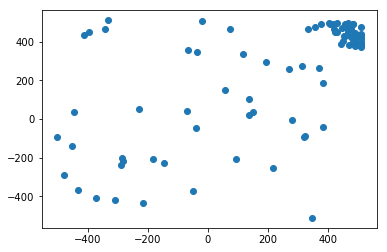

In [8]:
plt.scatter([list(particles.best_position.values())[ii]['0'] for ii in range(particles.nop)],
            [list(particles.best_position.values())[ii]['1'] for ii in range(particles.nop)])

In [9]:
particles.member[list(particles.best_position_ever.keys())[0]]

{'center': (997, 910),
 'best_value': -959.6398739562096,
 'position': {'0': 484.74883900822437, '1': 398.3097432816658},
 'best_position': {'0': 512, '1': 404.2581434263481},
 'velocity': {'0': 20.0, '1': -20.0},
 'fitness_value': -393.5104058208818,
 'distance': {'0': {'0': -27.251160991775635, '1': -26.819103658653034},
  '1': {'0': 77.80729255839043, '1': -93.73203525870355},
  '2': {'0': 520.5664314836011, '1': 48.455675172085535},
  '3': {'0': -27.251160991775635, '1': 12.642905255627227},
  '4': {'0': 159.852144105087, '1': 488.0426036256485},
  '5': {'0': 39.406898507780284, '1': 9.299059479085145},
  '6': {'0': 348.30370347685334, '1': 378.83408804297267},
  '7': {'0': 37.78580841509728, '1': -74.64789513266015},
  '8': {'0': 33.27639304468619, '1': -6.857722319292975},
  '9': {'0': 64.37379300277223, '1': -67.99453848817507},
  '10': {'0': 18.04583370147094, '1': -99.4622568641879},
  '11': {'0': -27.251160991775635, '1': -28.38866169937205},
  '12': {'0': -7.251160991775635,